*  Link for dataset
* https://gist.github.com/sachinsdate/2f4fb513f3a5ca367ae1866e3f5b8613
* The data set contains hourly readings of various air pollutants measured at a busy intersection in an Italian city from 2004 to 2005
* Link for code
* https://timeseriesreasoning.com/contents/regression-with-arima-errors-model/ 

In [9]:
import pandas as pd
from statsmodels.regression import linear_model
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [10]:
#read dataset
#header = 0 represents the row number to be used as header, its default too so not reqd
df = pd.read_csv('air_quality_uci_mod.csv', header=0)
df.head()

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
0,03-10-04 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,03-10-04 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,03-10-04 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,03-10-04 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,03-10-04 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [11]:
# fit a regression model to predict the hourly value of the PT08_S4_NO2 variable.
# Dependent variable y is PT08_S4_NO2, Independent variables/features Temperature T,  Absolute Humidity AH
#Check the datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DateTime      7344 non-null   object 
 1   CO_GT         7344 non-null   float64
 2   PT08_S1_CO    7344 non-null   int64  
 3   NMHC_GT       7344 non-null   int64  
 4   C6H6_GT       7344 non-null   float64
 5   PT08_S2_NMHC  7344 non-null   int64  
 6   NOx_GT        7344 non-null   int64  
 7   PT08_S3_NOx   7344 non-null   int64  
 8   NO2_GT        7344 non-null   int64  
 9   PT08_S4_NO2   7344 non-null   int64  
 10  PT08_S5_O3    7344 non-null   int64  
 11  T             7344 non-null   float64
 12  RH            7344 non-null   float64
 13  AH            7344 non-null   float64
dtypes: float64(5), int64(8), object(1)
memory usage: 803.4+ KB


In [12]:
##Observe the datetime is an object type so we convert it into a pandas DateTime column and 
#set it as the index of the DataFrame.
# Step 1: Data Preparation 

df['DateTimeIndex']= pd.to_datetime(df['DateTime'])
df = df.set_index(keys=['DateTimeIndex'])
df.head()
#df.shape

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
DateTimeIndex,,,,,,,,,,,,,,
2004-03-10 18:00:00,03-10-04 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
2004-03-10 19:00:00,03-10-04 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2004-03-10 20:00:00,03-10-04 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
2004-03-10 21:00:00,03-10-04 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
2004-03-10 22:00:00,03-10-04 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [13]:
# Step 1 DataPreparation
# Set the frequency attribute of the index to Hourly. 
#This will create several empty rows for  the missing hourly measurements in the original data set. 
# Fill up all the empty data cells with the mean of the corresponding column.

df = df.asfreq('H')
df = df.fillna(df.mean())
df.head(10)

,DateTime,CO_GT,PT08_S1_CO,NMHC_GT,C6H6_GT,PT08_S2_NMHC,NOx_GT,PT08_S3_NOx,NO2_GT,PT08_S4_NO2,PT08_S5_O3,T,RH,AH
DateTimeIndex,,,,,,,,,,,,,,
2004-03-10 18:00:00,03-10-04 18:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,03-10-04 19:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,03-10-04 20:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,03-10-04 21:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,03-10-04 22:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
2004-03-10 23:00:00,03-10-04 23:00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848
2004-03-11 00:00:00,03-11-04 00:00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603
2004-03-11 01:00:00,03-11-04 01:00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702
2004-03-11 02:00:00,03-11-04 02:00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648


In [14]:
# Step 1 DataPreparation
# Check that there are no missing values in the dataset

#df.isin([np.nan, np.inf, -np.inf]).sum()
df.reset_index(inplace=True)
print(df.head(10))

        DateTimeIndex        DateTime  CO_GT  PT08_S1_CO  NMHC_GT  C6H6_GT  \
0 2004-03-10 18:00:00  03-10-04 18:00    2.6      1360.0    150.0     11.9   
1 2004-03-10 19:00:00  03-10-04 19:00    2.0      1292.0    112.0      9.4   
2 2004-03-10 20:00:00  03-10-04 20:00    2.2      1402.0     88.0      9.0   
3 2004-03-10 21:00:00  03-10-04 21:00    2.2      1376.0     80.0      9.2   
4 2004-03-10 22:00:00  03-10-04 22:00    1.6      1272.0     51.0      6.5   
5 2004-03-10 23:00:00  03-10-04 23:00    1.2      1197.0     38.0      4.7   
6 2004-03-11 00:00:00  03-11-04 00:00    1.2      1185.0     31.0      3.6   
7 2004-03-11 01:00:00  03-11-04 01:00    1.0      1136.0     31.0      3.3   
8 2004-03-11 02:00:00  03-11-04 02:00    0.9      1094.0     24.0      2.3   
9 2004-03-11 03:00:00  03-11-04 03:00    0.6      1010.0     19.0      1.7   

   PT08_S2_NMHC  NOx_GT  PT08_S3_NOx  NO2_GT  PT08_S4_NO2  PT08_S5_O3     T  \
0        1046.0   166.0       1056.0   113.0       1692.0     

In [7]:
#Selecting the date and 'PT08_S4_NO2' columns

data=pd.DataFrame(df[['DateTimeIndex', 'PT08_S4_NO2']])
data.head()
#data.info()

,DateTimeIndex,PT08_S4_NO2
0,2004-03-10 18:00:00,1692.0
1,2004-03-10 19:00:00,1559.0
2,2004-03-10 20:00:00,1555.0
3,2004-03-10 21:00:00,1584.0
4,2004-03-10 22:00:00,1490.0


In [15]:
# Reset the index  we can set the date column as the index
#now we have the average pollutant corrsponding to each datetime
#data['DateTimeIndex'] = pd.to_datetime(data['DateTime'])

data.set_index("DateTimeIndex", inplace=True)
print(data.head())
##print(data.info())

                     PT08_S4_NO2
DateTimeIndex                   
2004-03-10 18:00:00       1692.0
2004-03-10 19:00:00       1559.0
2004-03-10 20:00:00       1555.0
2004-03-10 21:00:00       1584.0
2004-03-10 22:00:00       1490.0


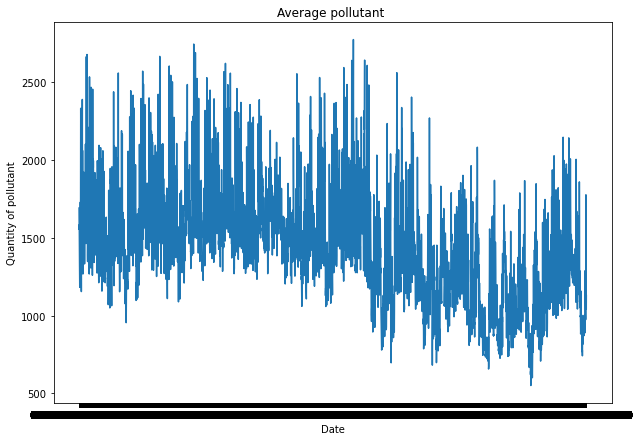

In [92]:
# to visualise the data graphically with a simple plot
plt.figure(figsize=(10,7))
plt.plot(data)               #Simple line plot plot(y)  # plot y using x as index array 0..N-1
plt.gca().set(title='Average pollutant ',xlabel='Date',ylabel='Quantity of pollutant');

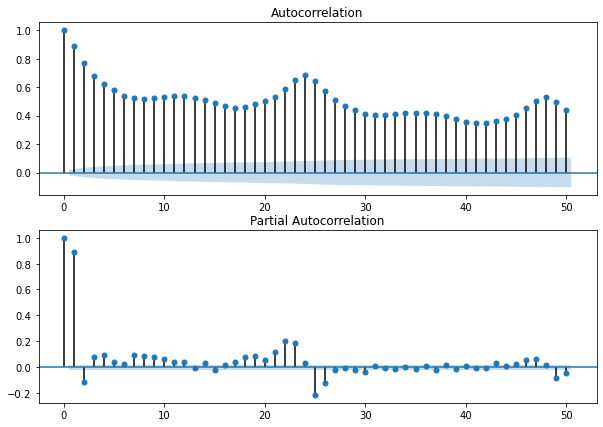

In [16]:
# Estimate the parameters of the Sarima using the acf PACF plots import the time series plots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10,7))
#plt.figure()
plt.subplot(211)
plot_acf(data.PT08_S4_NO2 , ax=plt.gca(),lags=50)   #equivalent to plot(lags, corr)
plt.subplot(212)
plot_pacf(data.PT08_S4_NO2 ,ax=plt.gca(),lags=50)
plt.show()

### Observations from the ACF
* Lag 0 correlation can be ignored as it will be always 1
* There are strong auto-correlations extending out to multiple lags indicating that the residual errors time series has a trend. * We’ll need to de-trend this time series by using one or possibly 2 orders of differencing. Thus, the parameter d is likely to be 1, or possibly 2.
* The wavelike pattern in the ACF evidences a seasonal variation in the data.
* The peak at LAG = 24 indicates that the seasonal period is likely to be 24 hours. i.e. m is likely to be 24. This seems reasonable for data containing vehicular pollution measurements. We’ll soon verify this guess using the time series decomposition plot.

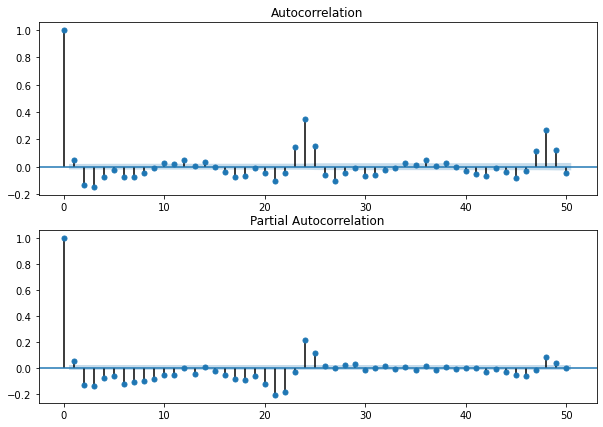

In [17]:
#lets do the differencing of the time series and again look at the acf pacf plots
data_d1=data.PT08_S4_NO2 .diff()[1:]
data_d1=data_d1.dropna()

plt.figure(figsize=(10,7))
#plt.figure()
plt.subplot(211)
plot_acf(data_d1 , ax=plt.gca(),lags=50, alpha=0.05)   #equivalent to plot(lags, corr)
plt.subplot(212)
plot_pacf(data_d1 ,ax=plt.gca(),lags=50, alpha=0.05)
plt.show()

### Observations from the ACF
* Positive autocorrelation at lag1

* Strong autocorrelation at lag 24

* We now see a very different picture in the ACF. The auto-correlations are significantly reduced at all lags. The wavelike pattern still exists but that’s because we did nothing to remove the possible seasonal variation. The LAG-24 auto-correlation is once again especially prominent.

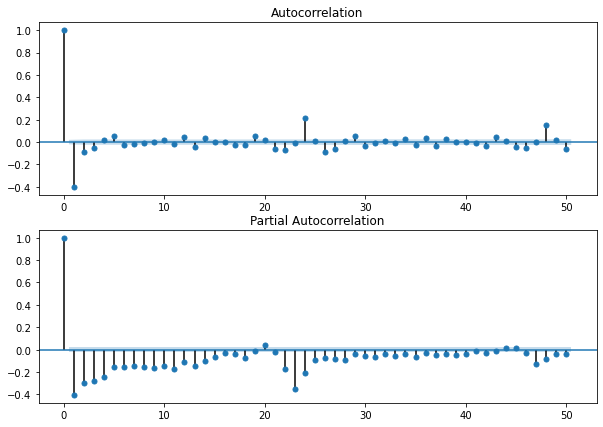

In [18]:
# we can take a second difference and check further
data_d2=data_d1.diff()[1:]
data_d2=data_d2.dropna()

plt.figure(figsize=(10,7))
#plt.figure()
plt.subplot(211)
plot_acf(data_d2 , ax=plt.gca(),lags=50, alpha=0.05)   #equivalent to plot(lags, corr)
plt.subplot(212)
plot_pacf(data_d2 ,ax=plt.gca(),lags=50, alpha=0.05)
plt.show()

### Observations from the ACF
* differencing the time series a second time has produced a heavy negative auto-correlation at LAG-1. This is bad sign. We seem to have over-done the differencing. We should stick with d=1.

### Define model parameters p,d,q
* The single positive auto-correlation at LAG-1 indicates that we may want to fix the AR order p to 1. i.e. an AR(1) model.
* Since we have fixed p to 1, for now, we’ll leave out the MA portion of the model. i.e. we fix q to 0.
* The PACF is showing positive prominent components at 1 and 24 which may be due to seasonal componenent
* for nonseasonal component we set q=0
* So far we have p=1, d=1, q=0

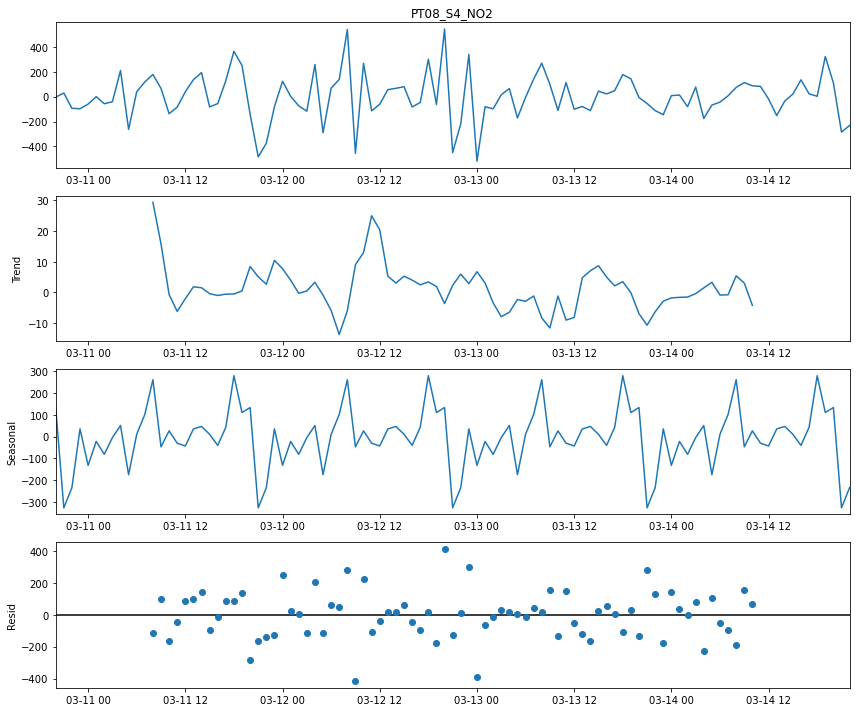

In [20]:
# Handle the seasonal part
# verify that the seasonal period m is 24 hours. use seasonal_decompose from statsmodels.tsa.seasonal 
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_d1[1:100], model='additive', period = 24)
fig = decomposition.plot()

### Observations from above plot
* The seasonal component confirms that m=24.
* The strong seasonal component warrants a single seasonal order of differencing, i.e. we set D=1.
* Apply single seasonal difference to our already differenced time series data_d1 after removing trend

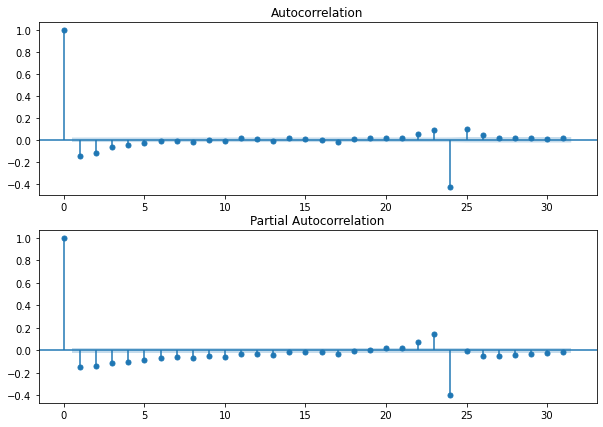

In [14]:
#apply a single seasonal difference to our already differenced time series
data_d3=data_d1.diff(periods = 24)[24:]

plt.figure(figsize=(10,7))
#plt.figure()
plt.subplot(211)
plot_acf(data_d3 , ax=plt.gca(),lags=31, alpha=0.05)   #equivalent to plot(lags, corr)
plt.subplot(212)
plot_pacf(data_d3 ,ax=plt.gca(),lags=31, alpha=0.05)
plt.show()

* Fit the SARIMAX model on the training data set (y_train, X_train) using the above parameters.
* For nonseasonal component p=1, d=1, q=0
* The strong seasonal component warrants a single seasonal order of differencing, i.e. we set D=1.
* The strong negative correlation at LAG-24 indicates a Seasonal MA (SMA) signature with order 1. i.e. Q=1. 
* Moreover, an absence of positive correlation at LAG-1, indicates an absence of a Seasonal AR component. i.e. P=0.
* We have fixed P=0, D=1 and Q=1, and m=24 hours
* estimate all 7 params of the SARIMA model as follows:
* p=1, d=1, q=0, P=0, D=1, Q=1 and m=24 i.e.  SARIMAX(1,1,0)(0,1,1)24

In [26]:
#importing and building auto arima model
#Auto_arima doesnt use aACF PACF concept to choose the udeal model
#it uses information criterion that is AIC
from pmdarima.arima import auto_arima

#data_N=data.T_mu.diff()[1:]
model = auto_arima(data_d1 , trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, seasonal=True)
#model = auto_arima(data_d1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=92983.034, Time=12.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=94233.985, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=94004.511, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=93923.557, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=94231.987, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=93046.430, Time=7.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=92982.458, Time=7.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=93898.686, Time=4.48 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=93759.773, Time=1.15 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=92983.033, Time=12.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=93618.520, Time=1.08 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=92980.884, Time=19.34 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=92982.744, Time=15.88 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=92981.962, Time=13.70 sec
 ARIMA(2,0,3)(

In [27]:
#do a train test split  and fit the model
# This will be done on the original model understand ACF PACF and differencing have been used to identify the parameters
#dividing the data into train and test and fitting the model 
#here we just take top 70 rows for modelling and remaing 30 rows for validation

df_train = data[:int(0.90*(len(data)))]
df_test= data[int(0.90*(len(data))):]

print(df_test.shape)

(735, 1)


In [81]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(df_train, order=(1, 1, 0), seasonal_order=(0, 1, 1, 24),enforce_stationarity=False,enforce_invertibility=False)
model_fit = model.fit(disp=False)

In [71]:
import numpy as np
from sklearn.metrics import mean_squared_error

pred = model_fit.forecast(len(df_test))
print(pred.head())
print(model_fit.summary())

#RMSE Score
print('RMSE :', np.sqrt(mean_squared_error(df_test, pred)))

5140    1290.633140
5141    1300.937727
5142    1305.613851
5143    1291.617923
5144    1300.876249
Name: predicted_mean, dtype: float64
                                      SARIMAX Results                                       
Dep. Variable:                          PT08_S4_NO2   No. Observations:                 5140
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 24)   Log Likelihood              -32937.669
Date:                              Sat, 19 Jun 2021   AIC                          65881.338
Time:                                      17:11:45   BIC                          65900.943
Sample:                                           0   HQIC                         65888.203
                                             - 5140                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

In [102]:
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#fitting the model
model = ARIMA(df_train.values, order=(5,1,5))
model_fit = model.fit(disp=0)
print(model_fit.summary())

#forecasting on validation data
output = model_fit.forecast(len(df_test))
print(len(output))                 #output is a tuple of 3 arrays forecast stderr and confidence interval
pred=output[0]                    #output[0] is the forecast

#RMSE Score
print('RMSE :', np.sqrt(mean_squared_error(df_test, pred)))

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 6608
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -41787.138
Method:                       css-mle   S.D. of innovations            134.919
Date:                Wed, 23 Jun 2021   AIC                          83598.276
Time:                        11:35:46   BIC                          83679.829
Sample:                             1   HQIC                         83626.460
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0558      0.351     -0.159      0.874      -0.743       0.631
ar.L1.D.y      1.5222      0.110     13.778      0.000       1.306       1.739
ar.L2.D.y     -1.0149      0.219     -4.641      0.0

In [ ]:
*  Bothe the coefficients are signofcant as P>|z| is less than 0.05
* Observe that the Ma component is negative